In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from forecast.weather import get_weather_data, get_train_test_sets, forecast_weather, forecast_weather_one_window

sns.set(font_scale=1.5, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Weather forecast

In [2]:
weather_data_path = '~/workspace/ds/data/AMPds/Climate_HourlyWeather.csv'
X, scaler = get_weather_data(weather_data_path)
X_train, X_test = get_train_test_sets(X)

In [3]:
X_train.shape, X_test.shape

((12230, 4), (5241, 4))

## Plot temperature prediction

In [4]:
X = np.concatenate((X_train, X_test))
predictions = forecast_weather(X)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000


In [5]:
predictions.shape

(17448, 4)

In [6]:
len(X_train) + len(X_test) + 24

17495

In [7]:
X_predictions = scaler.inverse_transform(predictions)
X_train_p = scaler.inverse_transform(X_train)
X_test_p = scaler.inverse_transform(X_test)

In [12]:
X_predictions.shape[0], X_train_p.shape[0] + X_test_p.shape[0]

(17448, 17471)

In [23]:
def plot_attribute(X_train, X_test, X_predictions, attr):
    attributes = ['Temp (C)', 'Dew Point Temp (C)', 'Visibility (km)', 'Stn Press (kPa)']
    attr_idx = attributes.index(attr)
    
    f, ax = plt.subplots(1, figsize=(20, 8))
    
    x = range(len(X_train) + len(X_test) + 1)
    train_trace = np.concatenate((X_train[:,attr_idx], [float('nan')] * (len(X_test) + 1)))
    test_trace = np.concatenate(([float('nan')] * len(X_train), X_test[:,attr_idx], [float('nan')]))
    forecast_trace = np.concatenate(([float('nan')] * 24, X_predictions[:,attr_idx]))
    
    ax.plot(x, train_trace, label='Train')
    ax.plot(x, test_trace, label='Test')
    ax.plot(x, forecast_trace, label='Forecast')
    
    ax.set_title(f'{attr} - Actual and Forecast')
    ax.legend()

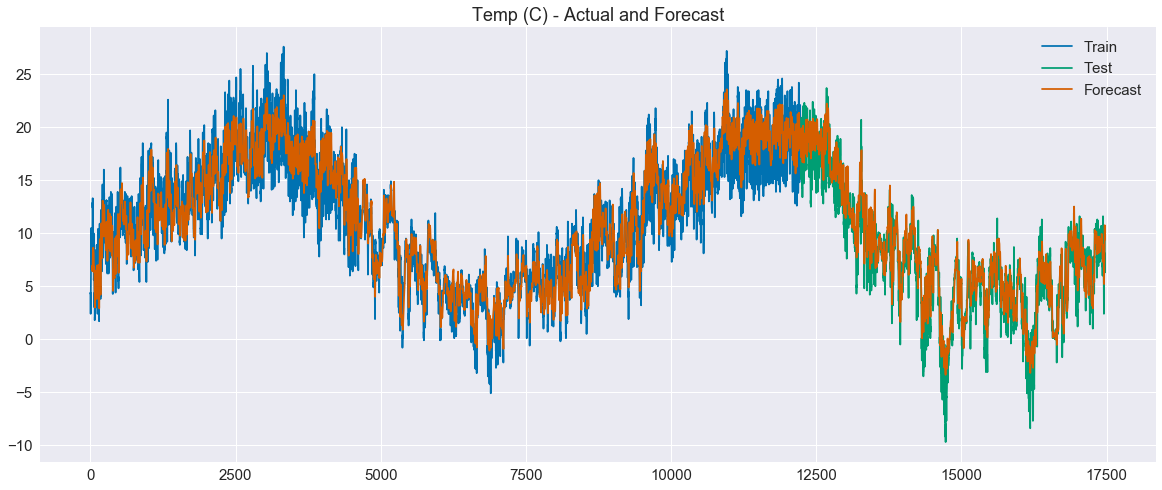

In [28]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Temp (C)')

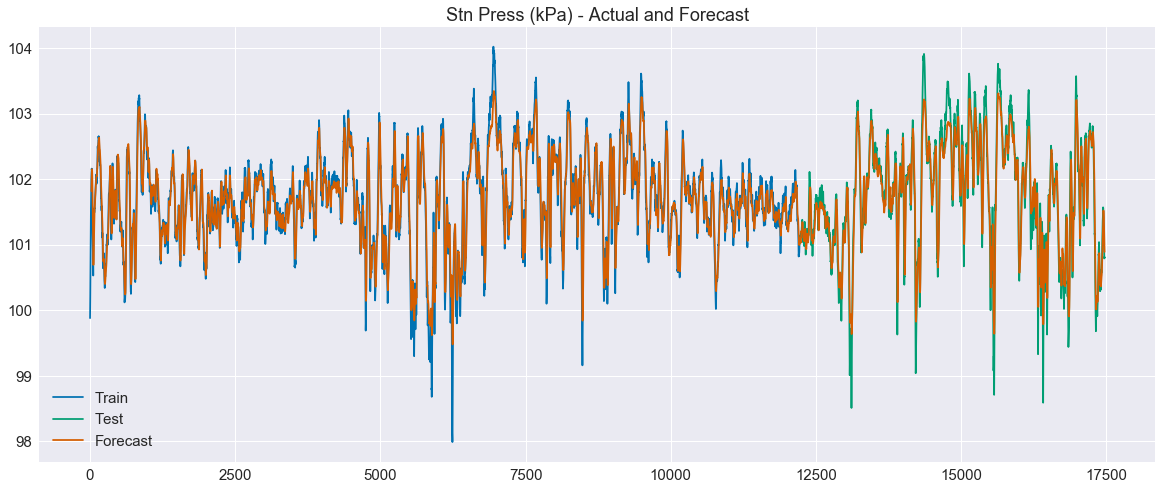

In [30]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Stn Press (kPa)')